# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm


**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [6]:
%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


100%|██████████| 66.0M/66.0M [00:00<00:00, 203MB/s]


In [7]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [ ]:
df['Class'].mean()

0.001727485630620034

Что-то около 0.17 % - реально маловато :)

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [8]:
df['hour'] = df['Time'] / 3600
df['day'] = round(df['hour'] / 24) # использую round так это более репрезентативно в дальнейшем исследовании
df['hour'] = df['hour'] % 24 // 1
days = int(df['day'].max())
print(f'Данные покрывают {days} дня')

Данные покрывают 2 дня


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

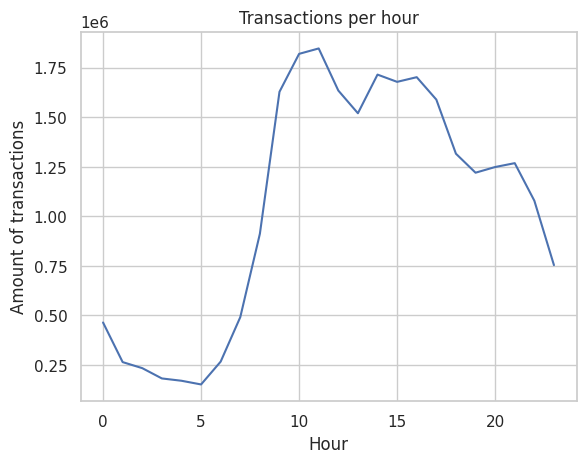

In [ ]:
grouping_hour = df.groupby('hour')
plt.title('Transactions per hour')
plt.xlabel('Hour')
plt.ylabel('Amount of transactions')
plt.plot(grouping_hour.sum().index, grouping_hour.sum()['Amount'])

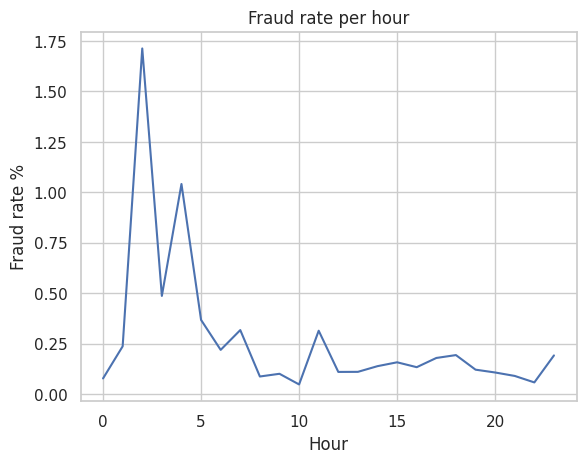

In [ ]:
plt.title('Fraud rate per hour')
plt.xlabel('Hour')
plt.ylabel('Fraud rate %')
plt.plot(grouping_hour.mean().index, grouping_hour.mean()['Class'] * 100)

<BarContainer object of 3 artists>

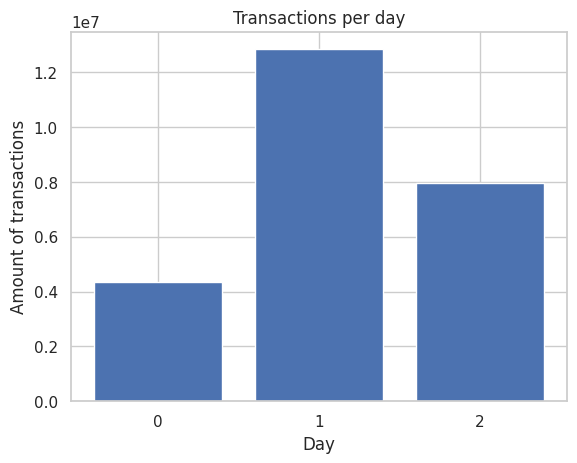

In [ ]:
grouping_day = df.groupby('day')
plt.title('Transactions per day')
plt.xlabel('Day')
plt.ylabel('Amount of transactions')
plt.bar(['0', '1', '2'], grouping_day.sum()['Amount'])

<BarContainer object of 3 artists>

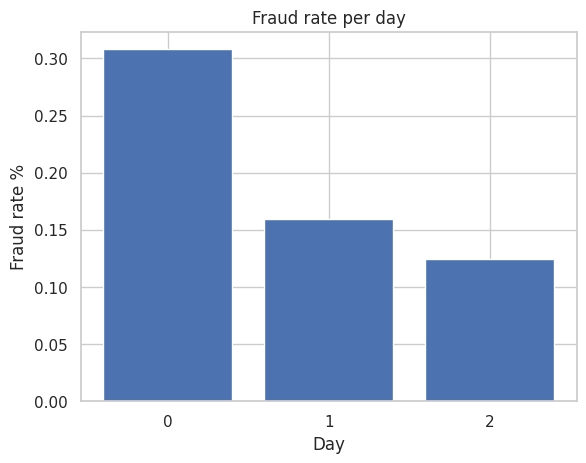

In [ ]:
plt.title('Fraud rate per day')
plt.xlabel('Day')
plt.ylabel('Fraud rate %')
plt.bar(['0', '1', '2'], grouping_day.mean()['Class'] * 100)

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [ ]:
corrs = df.corr()
most_correlated = corrs[(abs(corrs['Class']) > 0.25) & (abs(corrs['Class']) < 1)] # < 1, просто чтобы не брать сам Class

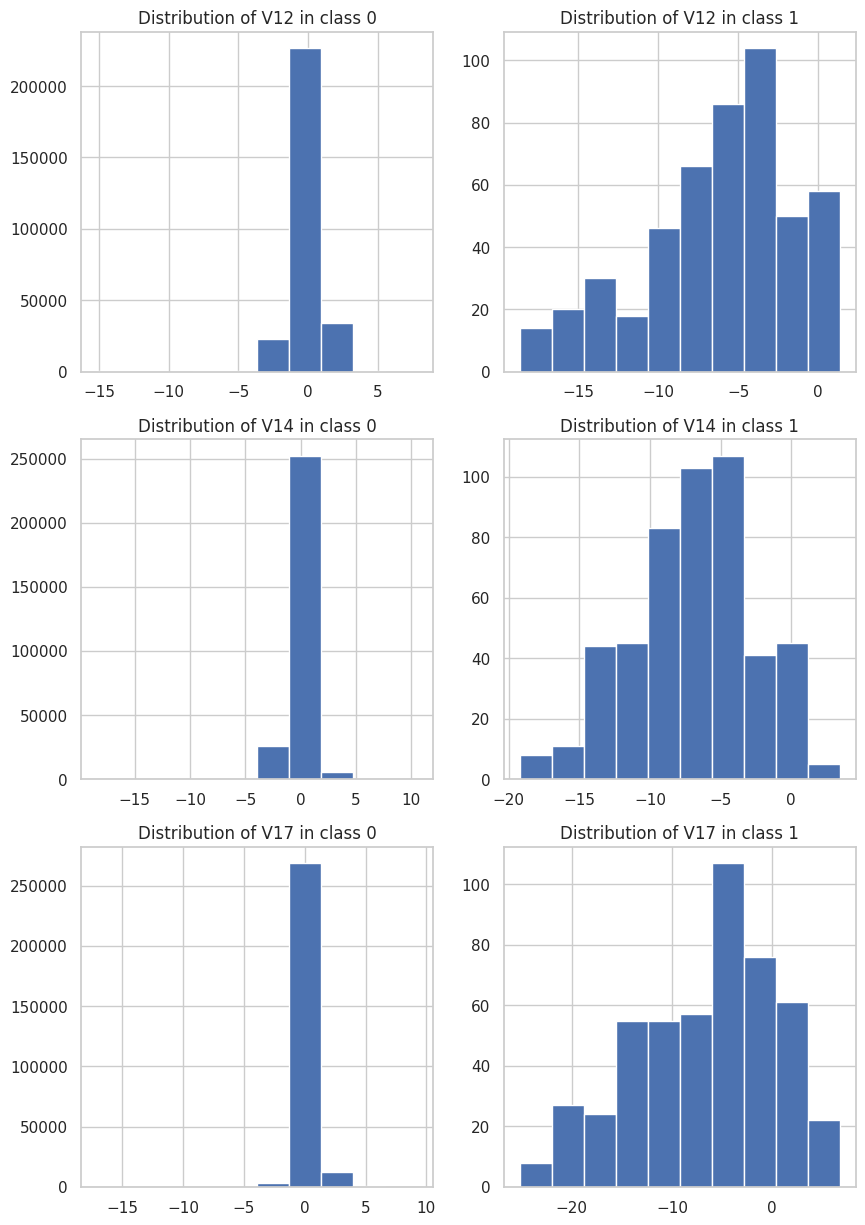

In [ ]:
plt.figure(figsize= (10,15))
for i in range(0,6):
    plt.subplot(3,2,i + 1)
    feature = most_correlated.index[(i) // 2]
    cl = (i) % 2
    plt.hist(df[df['Class'] == cl][feature])
    plt.title(f'Distribution of {feature} in class {cl}')

plt.show()

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis = 1), df['Class'], shuffle=False, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.1 / 0.9)
X_train.shape[0], X_val.shape[0], X_test.shape[0]

(227845, 28481, 28481)

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога.

In [10]:
from sklearn.metrics import roc_auc_score

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [11]:
from sklearn.metrics import accuracy_score
def Cohen_Kappa(y_true, y_pred):
  p_o = accuracy_score(y_true, y_pred)
  p_e = np.mean(y_true) * np.mean(y_pred) + (1 - np.mean(y_true)) * (1 - np.mean(y_pred))
  return (p_o - p_e) / (1 - p_e)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом.

In [12]:
def MCC(y_true, y_pred):
  TP = (y_true * y_pred).sum()
  TN = ((y_true - 1) * (y_pred - 1)).sum()
  FP = -((y_true - 1) * y_pred).sum()
  FN = -((y_true) * (y_pred - 1)).sum()
  # понял, что можно гораздо легче через confusion matrix, но уже так оставил :)
  assert TP + TN + FP + FN == y_true.shape[0]
  return (TP * TN - FP * FN) / ((TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [ ]:
# AUC-PR
roc_auc_score(df['Class'], np.zeros(df.shape[0]))

0.5

In [ ]:
# Cohen_Kappa
Cohen_Kappa(df['Class'], np.zeros(df.shape[0]))

0.0

In [ ]:
# MCC
MCC(df['Class'], np.zeros(df.shape[0]))

<ipython-input-11-151580dff574>:8: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / ((TP +FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5


nan

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`).

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_train, y_train)
pred = cb.predict(X_test)

0:	learn: 0.3813965	total: 132ms	remaining: 19.7s
1:	learn: 0.2135954	total: 342ms	remaining: 25.3s
2:	learn: 0.1135321	total: 516ms	remaining: 25.3s
3:	learn: 0.0637628	total: 631ms	remaining: 23s
4:	learn: 0.0381526	total: 702ms	remaining: 20.4s
5:	learn: 0.0245081	total: 775ms	remaining: 18.6s
6:	learn: 0.0167302	total: 838ms	remaining: 17.1s
7:	learn: 0.0115916	total: 896ms	remaining: 15.9s
8:	learn: 0.0086797	total: 961ms	remaining: 15.1s
9:	learn: 0.0067394	total: 1.02s	remaining: 14.2s
10:	learn: 0.0055309	total: 1.08s	remaining: 13.7s
11:	learn: 0.0047949	total: 1.14s	remaining: 13.1s
12:	learn: 0.0042333	total: 1.2s	remaining: 12.7s
13:	learn: 0.0038209	total: 1.28s	remaining: 12.5s
14:	learn: 0.0035341	total: 1.35s	remaining: 12.1s
15:	learn: 0.0033238	total: 1.46s	remaining: 12.2s
16:	learn: 0.0031647	total: 1.59s	remaining: 12.5s
17:	learn: 0.0030091	total: 1.72s	remaining: 12.6s
18:	learn: 0.0029137	total: 1.82s	remaining: 12.6s
19:	learn: 0.0028368	total: 1.88s	remaining:

In [ ]:
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

AUC-PR: 0.8181291107781848
Cohen_Kappa: 0.717758652842163
MCC: 0.7237392722838328


Не юзал никак валидацию тут, потому что получилость с первого прогона обучить до 0.7 на тесте, параметры взял с модели из домашки по [random-features](https://colab.research.google.com/drive/13q7fEU_kKSlOlwj0Y7tHDK8JrIq1Iez7#scrollTo=8sSElRio50up)

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [ ]:
negative = df[df['Class'] == 0].shape[0]
positive = df.shape[0] - negative

In [ ]:
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1, scale_pos_weight = negative // positive)
cb.fit(X_train, y_train)
pred = cb.predict(X_test)

0:	learn: 0.5173121	total: 77ms	remaining: 11.5s
1:	learn: 0.4083036	total: 152ms	remaining: 11.2s
2:	learn: 0.3202988	total: 221ms	remaining: 10.8s
3:	learn: 0.2487439	total: 297ms	remaining: 10.8s
4:	learn: 0.2268274	total: 365ms	remaining: 10.6s
5:	learn: 0.2005369	total: 433ms	remaining: 10.4s
6:	learn: 0.1751682	total: 507ms	remaining: 10.4s
7:	learn: 0.1597034	total: 611ms	remaining: 10.8s
8:	learn: 0.1405811	total: 767ms	remaining: 12s
9:	learn: 0.1291945	total: 911ms	remaining: 12.8s
10:	learn: 0.1205935	total: 1.03s	remaining: 13.1s
11:	learn: 0.1126874	total: 1.11s	remaining: 12.8s
12:	learn: 0.1053523	total: 1.18s	remaining: 12.5s
13:	learn: 0.0956763	total: 1.27s	remaining: 12.3s
14:	learn: 0.0918954	total: 1.35s	remaining: 12.1s
15:	learn: 0.0859311	total: 1.42s	remaining: 11.9s
16:	learn: 0.0821300	total: 1.5s	remaining: 11.7s
17:	learn: 0.0795316	total: 1.56s	remaining: 11.5s
18:	learn: 0.0757846	total: 1.64s	remaining: 11.3s
19:	learn: 0.0724280	total: 1.71s	remaining: 

In [ ]:
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

AUC-PR: 0.8634255340218305
Cohen_Kappa: 0.6396882805812039
MCC: 0.6443525381406625


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части.

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [ ]:
negative // positive

577

In [ ]:
# сначала подберу гиперпараметр на pr-auc
scores = []
weights = []
best_w = 200
best_sc = 0
for weight in range(400, 811, 35):
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1, scale_pos_weight = weight)
  cb.fit(X_train, y_train)
  pred = cb.predict(X_val)
  sc = roc_auc_score(y_val, pred)

  if sc > best_sc:
    best_sc = sc
    best_w = weight

  scores.append(sc)
  weights.append(weight)

0:	learn: 0.5236516	total: 208ms	remaining: 31s
1:	learn: 0.4127897	total: 371ms	remaining: 27.5s
2:	learn: 0.3170847	total: 572ms	remaining: 28.1s
3:	learn: 0.2449743	total: 746ms	remaining: 27.2s
4:	learn: 0.2225316	total: 976ms	remaining: 28.3s
5:	learn: 0.1967669	total: 1.09s	remaining: 26.1s
6:	learn: 0.1681937	total: 1.3s	remaining: 26.5s
7:	learn: 0.1540420	total: 1.49s	remaining: 26.5s
8:	learn: 0.1398818	total: 1.63s	remaining: 25.5s
9:	learn: 0.1312380	total: 1.78s	remaining: 25s
10:	learn: 0.1201930	total: 1.97s	remaining: 24.9s
11:	learn: 0.1130491	total: 2.18s	remaining: 25s
12:	learn: 0.1057374	total: 2.33s	remaining: 24.6s
13:	learn: 0.0999462	total: 2.5s	remaining: 24.3s
14:	learn: 0.0938129	total: 2.65s	remaining: 23.8s
15:	learn: 0.0880229	total: 2.88s	remaining: 24.2s
16:	learn: 0.0846463	total: 3.08s	remaining: 24.1s
17:	learn: 0.0821040	total: 3.23s	remaining: 23.7s
18:	learn: 0.0788417	total: 3.41s	remaining: 23.5s
19:	learn: 0.0751313	total: 3.58s	remaining: 23.3

In [ ]:
scores, weights

([0.8867396879504926,
  0.8961560619214115,
  0.8867220996572606,
  0.8866517464843325,
  0.8867220996572606,
  0.8867045113640286,
  0.8961208853349475,
  0.8866165698978684,
  0.8961032970417154,
  0.8866517464843325,
  0.8866693347775645,
  0.8960857087484834],
 [400, 435, 470, 505, 540, 575, 610, 645, 680, 715, 750, 785])

In [ ]:
best_w, best_sc

(435, 0.8961560619214115)

Любопытно проверить метрики на весах меньше 1 для минорного класса

In [ ]:
scores = []
weights = []
best_w = 200
best_sc = 0
for weight in np.linspace(0.55, 0.65, 10):
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1, scale_pos_weight = weight)
  cb.fit(X_train, y_train)
  pred = cb.predict(X_val)
  sc = roc_auc_score(y_val, pred)

  if sc > best_sc:
    best_sc = sc
    best_w = weight

  scores.append(sc)
  weights.append(weight)

0:	learn: 0.3698693	total: 71.2ms	remaining: 10.6s
1:	learn: 0.2004683	total: 150ms	remaining: 11.1s
2:	learn: 0.1146178	total: 222ms	remaining: 10.9s
3:	learn: 0.0622088	total: 292ms	remaining: 10.7s
4:	learn: 0.0354819	total: 353ms	remaining: 10.2s
5:	learn: 0.0213131	total: 422ms	remaining: 10.1s
6:	learn: 0.0135245	total: 483ms	remaining: 9.87s
7:	learn: 0.0092884	total: 544ms	remaining: 9.66s
8:	learn: 0.0066933	total: 611ms	remaining: 9.57s
9:	learn: 0.0051096	total: 670ms	remaining: 9.38s
10:	learn: 0.0040694	total: 731ms	remaining: 9.24s
11:	learn: 0.0033916	total: 799ms	remaining: 9.19s
12:	learn: 0.0029620	total: 876ms	remaining: 9.23s
13:	learn: 0.0026376	total: 934ms	remaining: 9.07s
14:	learn: 0.0023700	total: 993ms	remaining: 8.94s
15:	learn: 0.0022052	total: 1.06s	remaining: 8.86s
16:	learn: 0.0020732	total: 1.11s	remaining: 8.71s
17:	learn: 0.0019705	total: 1.18s	remaining: 8.64s
18:	learn: 0.0018735	total: 1.24s	remaining: 8.57s
19:	learn: 0.0018059	total: 1.31s	remain

In [ ]:
best_sc, best_w

(0.8773584905660378, 0.5722222222222223)

После поисков метрики тоже выпадали достаточно хорошие, но уже хуже, чем с экстримальными весами для миноргого класса (что интиутивно неудивительно)

Дальше буду использовать гиперпараметр, при котором получилась лучшая метрика

In [ ]:
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1, scale_pos_weight = 675) # 675
cb.fit(X_train, y_train)
pred = cb.predict(X_val)
roc_auc_score(y_val, pred)

0:	learn: 0.5168152	total: 68.7ms	remaining: 10.2s
1:	learn: 0.4035645	total: 132ms	remaining: 9.73s
2:	learn: 0.3218423	total: 196ms	remaining: 9.62s
3:	learn: 0.2641113	total: 265ms	remaining: 9.66s
4:	learn: 0.2175023	total: 335ms	remaining: 9.71s
5:	learn: 0.1934613	total: 411ms	remaining: 9.87s
6:	learn: 0.1679443	total: 480ms	remaining: 9.8s
7:	learn: 0.1555538	total: 546ms	remaining: 9.69s
8:	learn: 0.1482216	total: 609ms	remaining: 9.54s
9:	learn: 0.1340648	total: 678ms	remaining: 9.49s
10:	learn: 0.1219752	total: 755ms	remaining: 9.54s
11:	learn: 0.1128551	total: 874ms	remaining: 10s
12:	learn: 0.1038756	total: 1.01s	remaining: 10.6s
13:	learn: 0.1014501	total: 1.13s	remaining: 11s
14:	learn: 0.0959155	total: 1.25s	remaining: 11.2s
15:	learn: 0.0894775	total: 1.38s	remaining: 11.5s
16:	learn: 0.0836817	total: 1.51s	remaining: 11.8s
17:	learn: 0.0813941	total: 1.64s	remaining: 12.1s
18:	learn: 0.0760933	total: 1.77s	remaining: 12.2s
19:	learn: 0.0710265	total: 1.9s	remaining: 1

0.9148832801038572

Короче далее я еще просто методом тыка в окрестности весов, при которых score получился 0.89, пытался найти что-то лучше и забрел на вес 675 - лучше него больше не получалось

In [ ]:
# посмотрим какой сейчас порог установлен
print(f'Cohen_Kappa: {Cohen_Kappa(y_val, pred)}')
print(f'MCC: {MCC(y_val, pred)}')
print(f'Threshold: {cb.get_probability_threshold()}')

Cohen_Kappa: 0.8069703562344501
MCC: 0.8072773484012582
Threshold: 0.5


Для более точной оценки я буду сравнивать сумму двух метрик, область ее значения [0; 2]

Буду подбирать гиперпараметр на модели с самым лучшим подобранным **scale_pos_weight** ранее

In [ ]:
best_sc = 0
best_thr = 0
for threshold in np.linspace(0.4, 0.8, 50):
  cb.set_probability_threshold(threshold)
  pred = cb.predict(X_val)
  mcc = MCC(y_val, pred)
  ck = Cohen_Kappa(y_val, pred)
  if mcc + ck > best_sc:
    best_sc = mcc + ck
    best_thr = threshold

In [ ]:
best_sc, best_thr

(1.7166759683831032, 0.7020408163265306)

Теперь итоговый прогон на тесте

In [ ]:
cb.set_probability_threshold(best_thr)
pred = cb.predict(X_test)

print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

AUC-PR: 0.8634782414254637
Cohen_Kappa: 0.6805885875737391
MCC: 0.6819815751994611


Получилось получше, чем без подбора гиперпараметров, однако все равно дойти до 0.7, как в самый первый раз без установки гиперпараметров не получилось. Видимо потому что устанавливаем эту константу на все обучение, не факт что она такая на всех объектах

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса.

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку.

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [ ]:
auc_pr = []
ck = []
mcc = []
for ss in [1, 1/2, 1/10]:
  sm = SMOTE(sampling_strategy=ss)
  X_res, y_res = sm.fit_resample(X_train, y_train)
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
  cb.fit(X_res, y_res)
  pred = cb.predict(X_test)
  auc_pr.append(roc_auc_score(y_test, pred))
  ck.append(Cohen_Kappa(y_test, pred))
  mcc.append(MCC(y_test, pred))

0:	learn: 0.4696350	total: 316ms	remaining: 47s
1:	learn: 0.3264847	total: 602ms	remaining: 44.6s
2:	learn: 0.2407190	total: 882ms	remaining: 43.2s
3:	learn: 0.1874765	total: 1.23s	remaining: 44.8s
4:	learn: 0.1571210	total: 1.5s	remaining: 43.6s
5:	learn: 0.1339021	total: 1.8s	remaining: 43.3s
6:	learn: 0.1161880	total: 2.15s	remaining: 43.9s
7:	learn: 0.1051471	total: 2.53s	remaining: 44.9s
8:	learn: 0.0952904	total: 2.93s	remaining: 45.9s
9:	learn: 0.0868696	total: 3.37s	remaining: 47.2s
10:	learn: 0.0815634	total: 3.72s	remaining: 47s
11:	learn: 0.0762345	total: 3.89s	remaining: 44.7s
12:	learn: 0.0717856	total: 4.11s	remaining: 43.3s
13:	learn: 0.0692103	total: 4.34s	remaining: 42.2s
14:	learn: 0.0649214	total: 4.58s	remaining: 41.2s
15:	learn: 0.0618773	total: 4.79s	remaining: 40.1s
16:	learn: 0.0597153	total: 4.98s	remaining: 39s
17:	learn: 0.0571235	total: 5.23s	remaining: 38.4s
18:	learn: 0.0551532	total: 5.47s	remaining: 37.7s
19:	learn: 0.0528498	total: 5.7s	remaining: 37.1s

In [ ]:
ratio = ['1:1', '1:2', '1:10']
res1 = pd.DataFrame(data={'AUC-PR' : auc_pr, 'Cohen_Kappa' : ck, 'MCC' : mcc}, index = ratio)
res1

,AUC-PR,Cohen_Kappa,MCC
1:1,0.863320,0.571026,0.584632
1:2,0.863461,0.666387,0.668717
1:10,0.863478,0.680589,0.681982


Улучшаются метрики CK и MCC при более неполных балансах классов на обучающей выборке, так как такой баланс является более близким к тесту, на котором мы и оцениваем метрики

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

**BorderlineSMOTE** - модернизированный SMOTE, который выбирает из k ближайших соседей только те объекты, которые лежат на границу классов. То есть они являются миноритарными, однако лежат относительно близко к мажоритарному, как раз самая сложность предсказания заключается в таких объектах.

**SVM-SMOTE** - ну тут все относительно легко. Это вариант алгоритма SMOTE, который использует алгоритм SVM для обнаружения примеров, рядом с которыми будут создаваться новые синтетические примеры (соответственно тут, ближайшие соседи будут построены немного иначе, согласно тому, как это сделает SVM)

**K-Means-SMOTE** - прикольный метод. Короче сначала объекты разделяются на k кластеров с помощью k-means, потом обходим кластеры где большинство объектов это миноритарный класс и в каждом кластере создаем новые миноритарные объекты. Причем, если пространство из этих миноритарных объектов более разреженно, тем больше новых объектов сгенерируется. Цель: уравнять плотность миноритарных объектов в каждом кластере.

**ADASYN** - вот здесь сложная идея конечно. Осознать примерно осознал. Более простого описания я сделать не смогу. Ключевой идеей алгоритма ADASYN является использование плотности распределения в качестве критерия для автоматического принятия решения о необходимом количестве для каждого элемента миноритарного подмножества путем адаптивного изменения весов различных элементов, миноритарного подмножества, что в итоге компенсирует неравномерное распределение (несбалансированность) данных.



Теперь попробуйте сравнить качество всех методов на наших данных.

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(sampling_strategy=0.1)
X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

0:	learn: 0.4212205	total: 248ms	remaining: 37s
1:	learn: 0.2503763	total: 402ms	remaining: 29.7s
2:	learn: 0.1483450	total: 543ms	remaining: 26.6s
3:	learn: 0.0861896	total: 695ms	remaining: 25.4s
4:	learn: 0.0561064	total: 844ms	remaining: 24.5s
5:	learn: 0.0396481	total: 985ms	remaining: 23.6s
6:	learn: 0.0282772	total: 1.13s	remaining: 23.1s
7:	learn: 0.0210393	total: 1.27s	remaining: 22.6s
8:	learn: 0.0173344	total: 1.39s	remaining: 21.8s
9:	learn: 0.0140118	total: 1.54s	remaining: 21.5s
10:	learn: 0.0120391	total: 1.66s	remaining: 21s
11:	learn: 0.0105841	total: 1.8s	remaining: 20.8s
12:	learn: 0.0091604	total: 1.92s	remaining: 20.3s
13:	learn: 0.0084214	total: 2.08s	remaining: 20.2s
14:	learn: 0.0078890	total: 2.19s	remaining: 19.7s
15:	learn: 0.0074458	total: 2.33s	remaining: 19.5s
16:	learn: 0.0069774	total: 2.46s	remaining: 19.3s
17:	learn: 0.0064124	total: 2.6s	remaining: 19.1s
18:	learn: 0.0062321	total: 2.73s	remaining: 18.8s
19:	learn: 0.0059277	total: 2.87s	remaining: 18

In [ ]:
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(sampling_strategy=0.1)
X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

0:	learn: 0.4025600	total: 254ms	remaining: 37.8s
1:	learn: 0.2278709	total: 483ms	remaining: 35.7s
2:	learn: 0.1290516	total: 763ms	remaining: 37.4s
3:	learn: 0.0785910	total: 958ms	remaining: 35s
4:	learn: 0.0521901	total: 1.37s	remaining: 39.8s
5:	learn: 0.0342002	total: 1.71s	remaining: 41s
6:	learn: 0.0240100	total: 2.07s	remaining: 42.4s
7:	learn: 0.0188412	total: 2.4s	remaining: 42.6s
8:	learn: 0.0145379	total: 2.57s	remaining: 40.3s
9:	learn: 0.0115223	total: 2.8s	remaining: 39.3s
10:	learn: 0.0101642	total: 2.96s	remaining: 37.5s
11:	learn: 0.0086370	total: 3.14s	remaining: 36.1s
12:	learn: 0.0076237	total: 3.35s	remaining: 35.4s
13:	learn: 0.0070795	total: 3.56s	remaining: 34.6s
14:	learn: 0.0065828	total: 3.74s	remaining: 33.7s
15:	learn: 0.0063167	total: 3.92s	remaining: 32.9s
16:	learn: 0.0059262	total: 4.08s	remaining: 32s
17:	learn: 0.0056434	total: 4.29s	remaining: 31.5s
18:	learn: 0.0053557	total: 4.48s	remaining: 30.9s
19:	learn: 0.0050739	total: 4.64s	remaining: 30.2

In [ ]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans
sm = KMeansSMOTE(kmeans_estimator = MiniBatchKMeans(n_clusters=100), sampling_strategy=0.1, k_neighbors=10, cluster_balance_threshold = 0.001)

X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0:	learn: 0.4023964	total: 94ms	remaining: 14s
1:	learn: 0.2167466	total: 164ms	remaining: 12.2s
2:	learn: 0.1237106	total: 234ms	remaining: 11.4s
3:	learn: 0.0727201	total: 314ms	remaining: 11.5s
4:	learn: 0.0456075	total: 383ms	remaining: 11.1s
5:	learn: 0.0292864	total: 451ms	remaining: 10.8s
6:	learn: 0.0193188	total: 524ms	remaining: 10.7s
7:	learn: 0.0141905	total: 593ms	remaining: 10.5s
8:	learn: 0.0110572	total: 657ms	remaining: 10.3s
9:	learn: 0.0088558	total: 734ms	remaining: 10.3s
10:	learn: 0.0079545	total: 797ms	remaining: 10.1s
11:	learn: 0.0070218	total: 861ms	remaining: 9.9s
12:	learn: 0.0059847	total: 922ms	remaining: 9.71s
13:	learn: 0.0052297	total: 996ms	remaining: 9.67s
14:	learn: 0.0048011	total: 1.06s	remaining: 9.53s
15:	learn: 0.0043836	total: 1.13s	remaining: 9.5s
16:	learn: 0.0040753	total: 1.2s	remaining: 9.4s
17:	learn: 0.0039368	total: 1.27s	remaining: 9.3s
18:	learn: 0.0037807	total: 1.33s	remaining: 9.2s
19:	learn: 0.0035827	total: 1.39s	remaining: 9.06s

In [ ]:
from imblearn.over_sampling import ADASYN
sm = ADASYN(sampling_strategy=0.1)

X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

0:	learn: 0.4908059	total: 83.5ms	remaining: 12.4s
1:	learn: 0.3304499	total: 223ms	remaining: 16.5s
2:	learn: 0.2440805	total: 343ms	remaining: 16.8s
3:	learn: 0.1770028	total: 476ms	remaining: 17.4s
4:	learn: 0.1389659	total: 594ms	remaining: 17.2s
5:	learn: 0.1048788	total: 735ms	remaining: 17.6s
6:	learn: 0.0835834	total: 890ms	remaining: 18.2s
7:	learn: 0.0695704	total: 1.07s	remaining: 18.9s
8:	learn: 0.0591104	total: 1.53s	remaining: 23.9s
9:	learn: 0.0530283	total: 1.99s	remaining: 27.8s
10:	learn: 0.0473207	total: 2.29s	remaining: 29s
11:	learn: 0.0432008	total: 2.44s	remaining: 28s
12:	learn: 0.0399949	total: 2.58s	remaining: 27.2s
13:	learn: 0.0370427	total: 2.72s	remaining: 26.4s
14:	learn: 0.0349603	total: 2.88s	remaining: 25.9s
15:	learn: 0.0329801	total: 3.01s	remaining: 25.2s
16:	learn: 0.0316799	total: 3.15s	remaining: 24.7s
17:	learn: 0.0304117	total: 3.28s	remaining: 24.1s
18:	learn: 0.0297067	total: 3.41s	remaining: 23.5s
19:	learn: 0.0289376	total: 3.55s	remaining:

Все кроме ADASYN показали лучший результат, скорее всего на ADASYN нужно будет просто поподбирать гиперпараметры, и он тоже покажет метрику получше

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
ck = []
mcc = []
balance = np.linspace(0.01, 0.8, 30)
X_res, y_res = X_train, y_train
dims = []
for ss in balance:
  rs = RandomUnderSampler(sampling_strategy=ss)
  X_res, y_res = rs.fit_resample(X_res, y_res)
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
  cb.fit(X_res, y_res)
  pred = cb.predict(X_test)
  ck.append(Cohen_Kappa(y_test, pred))
  mcc.append(MCC(y_test, pred))
  dims.append(X_train.shape[0] / y_res.shape[0])


0:	learn: 0.4422451	total: 19.7ms	remaining: 2.93s
1:	learn: 0.2679692	total: 39.1ms	remaining: 2.9s
2:	learn: 0.1691448	total: 58.7ms	remaining: 2.88s
3:	learn: 0.1118860	total: 80.2ms	remaining: 2.93s
4:	learn: 0.0759132	total: 112ms	remaining: 3.26s
5:	learn: 0.0541393	total: 137ms	remaining: 3.28s
6:	learn: 0.0392259	total: 160ms	remaining: 3.27s
7:	learn: 0.0302843	total: 185ms	remaining: 3.28s
8:	learn: 0.0248223	total: 207ms	remaining: 3.25s
9:	learn: 0.0210429	total: 260ms	remaining: 3.64s
10:	learn: 0.0182335	total: 306ms	remaining: 3.87s
11:	learn: 0.0164426	total: 338ms	remaining: 3.89s
12:	learn: 0.0147649	total: 370ms	remaining: 3.9s
13:	learn: 0.0139086	total: 394ms	remaining: 3.83s
14:	learn: 0.0133242	total: 419ms	remaining: 3.77s
15:	learn: 0.0125589	total: 469ms	remaining: 3.93s
16:	learn: 0.0120751	total: 507ms	remaining: 3.96s
17:	learn: 0.0116939	total: 559ms	remaining: 4.1s
18:	learn: 0.0114294	total: 603ms	remaining: 4.15s
19:	learn: 0.0111678	total: 648ms	remain

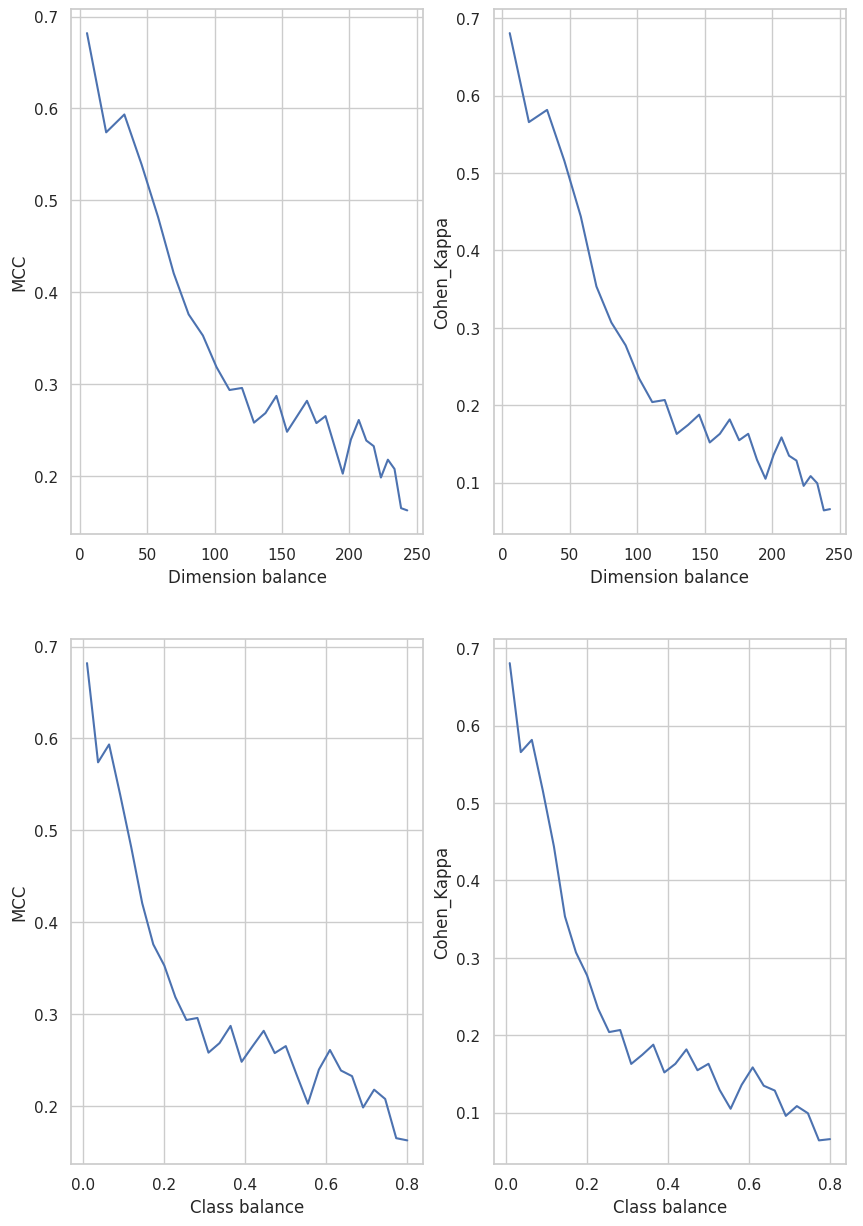

In [ ]:
metrics = [mcc, ck]
samples = [dims, balance]
names_m = ['MCC', 'Cohen_Kappa']
names_s = ['Dimension balance', 'Class balance']
plt.figure(figsize= (10,15))
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    m = i % 2
    s = i // 2
    plt.plot(samples[s], metrics[m])
    plt.xlabel(names_s[s])
    plt.ylabel(names_m[m])

plt.show()

Видим опять же такой тренд, что чем ближе баланс классов к балансу в тесте, тем метрики лучше.

Также, по-моему мнению, стоит отметить отличительное преимущество данного метода в том, что он уменьшает нашу выборку, от этого обучение становится гораздо быстрее, а метрика остается на этом же уровне или даже лучше!

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
ck = []
mcc = []
balance = np.linspace(0.003, 0.1, 30)

dims = []
for ss in balance:
  nm = NearMiss(sampling_strategy=ss)
  X_res, y_res = nm.fit_resample(X_train, y_train)
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
  cb.fit(X_res, y_res)
  pred = cb.predict(X_test)
  ck.append(Cohen_Kappa(y_test, pred))
  mcc.append(MCC(y_test, pred))
  dims.append(X_train.shape[0] / y_res.shape[0])

0:	learn: 0.3976728	total: 42.9ms	remaining: 6.39s
1:	learn: 0.2225474	total: 84.3ms	remaining: 6.24s
2:	learn: 0.1231475	total: 128ms	remaining: 6.26s
3:	learn: 0.0749181	total: 172ms	remaining: 6.27s
4:	learn: 0.0466508	total: 218ms	remaining: 6.33s
5:	learn: 0.0312370	total: 265ms	remaining: 6.36s
6:	learn: 0.0218899	total: 306ms	remaining: 6.25s
7:	learn: 0.0159186	total: 345ms	remaining: 6.12s
8:	learn: 0.0122220	total: 386ms	remaining: 6.04s
9:	learn: 0.0097227	total: 425ms	remaining: 5.95s
10:	learn: 0.0081006	total: 476ms	remaining: 6.01s
11:	learn: 0.0070695	total: 526ms	remaining: 6.05s
12:	learn: 0.0062419	total: 566ms	remaining: 5.97s
13:	learn: 0.0056532	total: 606ms	remaining: 5.88s
14:	learn: 0.0052714	total: 649ms	remaining: 5.84s
15:	learn: 0.0049506	total: 709ms	remaining: 5.94s
16:	learn: 0.0047104	total: 750ms	remaining: 5.87s
17:	learn: 0.0045297	total: 794ms	remaining: 5.82s
18:	learn: 0.0043244	total: 836ms	remaining: 5.76s
19:	learn: 0.0041610	total: 875ms	remai

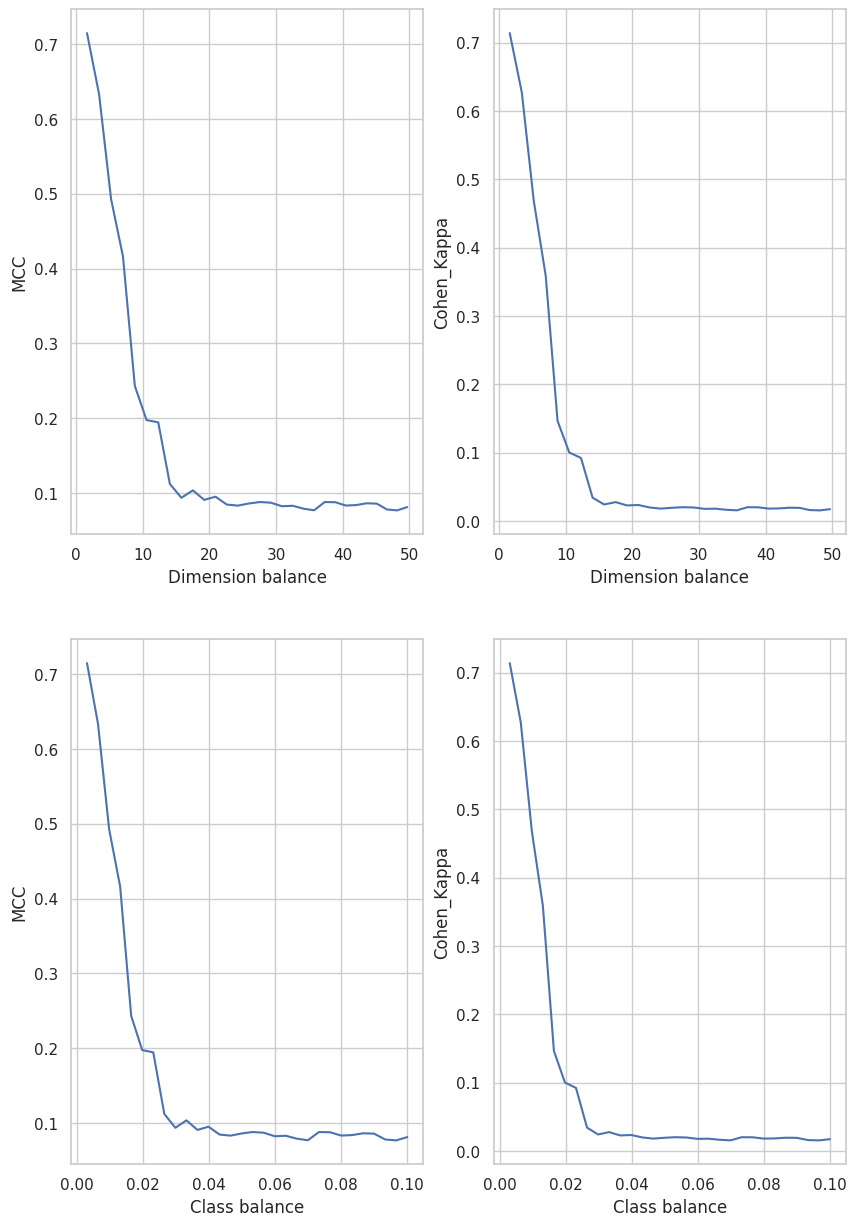

In [ ]:
metrics = [mcc, ck]
samples = [dims, balance]
names_m = ['MCC', 'Cohen_Kappa']
names_s = ['Dimension balance', 'Class balance']
plt.figure(figsize= (10,15))
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    m = i % 2
    s = i // 2
    plt.plot(samples[s], metrics[m])
    plt.xlabel(names_s[s])
    plt.ylabel(names_m[m])

plt.show()

Теперь при балансе классов 0.003 (именно на этом показателе метрика была самая лучшая в предыдущих прогонах) я проэкспереминтирую с k-ближайшими соседями

In [ ]:
ck = []
mcc = []
neighbors = [i for i in range(1, 50, 2)]
for neighbor in neighbors:
  nm = NearMiss(sampling_strategy=0.003, n_neighbors = neighbor)
  X_res, y_res = nm.fit_resample(X_train, y_train)
  cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
  cb.fit(X_res, y_res)
  pred = cb.predict(X_test)
  ck.append(Cohen_Kappa(y_test, pred))
  mcc.append(MCC(y_test, pred))


0:	learn: 0.3978047	total: 79ms	remaining: 11.8s
1:	learn: 0.2226032	total: 187ms	remaining: 13.9s
2:	learn: 0.1239810	total: 283ms	remaining: 13.9s
3:	learn: 0.0751154	total: 334ms	remaining: 12.2s
4:	learn: 0.0470000	total: 379ms	remaining: 11s
5:	learn: 0.0308302	total: 419ms	remaining: 10.1s
6:	learn: 0.0213131	total: 462ms	remaining: 9.44s
7:	learn: 0.0154477	total: 507ms	remaining: 9s
8:	learn: 0.0118796	total: 547ms	remaining: 8.56s
9:	learn: 0.0095465	total: 584ms	remaining: 8.17s
10:	learn: 0.0079603	total: 623ms	remaining: 7.87s
11:	learn: 0.0068995	total: 684ms	remaining: 7.87s
12:	learn: 0.0060215	total: 728ms	remaining: 7.67s
13:	learn: 0.0053988	total: 770ms	remaining: 7.48s
14:	learn: 0.0050581	total: 817ms	remaining: 7.36s
15:	learn: 0.0047661	total: 855ms	remaining: 7.16s
16:	learn: 0.0045477	total: 894ms	remaining: 6.99s
17:	learn: 0.0043249	total: 942ms	remaining: 6.9s
18:	learn: 0.0041630	total: 981ms	remaining: 6.76s
19:	learn: 0.0040720	total: 1.02s	remaining: 6.6

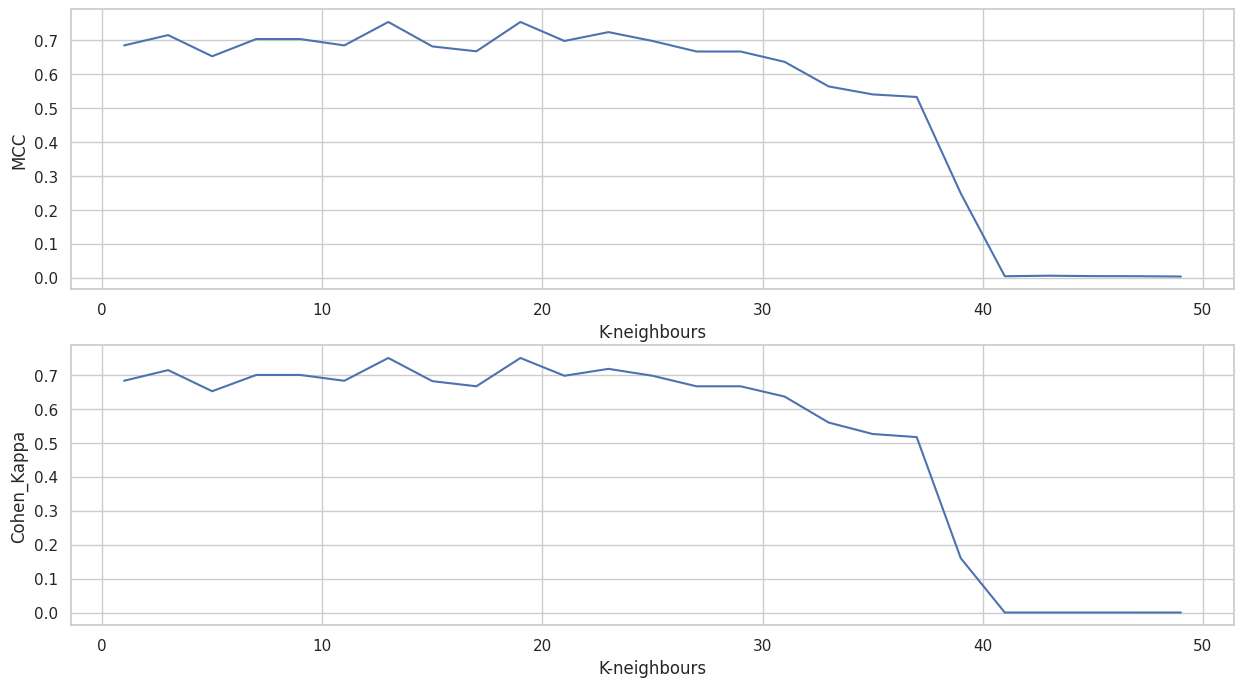

In [ ]:
metrics = [mcc, ck]
names_m = ['MCC', 'Cohen_Kappa']

plt.figure(figsize= (15,8))
for i in range(0, 2):
    plt.subplot(2, 1, i + 1)
    m = i % 2
    plt.plot(neighbors, metrics[m])
    plt.xlabel('K-neighbours')
    plt.ylabel(names_m[m])

plt.show()

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Показался интересным и понятным метод [ClusterCentroids](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.ClusterCentroids.html)

Прогоняется алгоритм K-Means над мажоритарной выборкой, затем все мажоритарные сэмплы заменяются на центроиды, которые образовались после K-Means, получится N сэмплов - N центроидов - настраиваемый гиперпараметр


In [ ]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(estimator = MiniBatchKMeans(n_clusters=1500), sampling_strategy=0.1)
X_res, y_res = cc.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(Cohen_Kappa(y_test, pred))
print(MCC(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0:	learn: 0.5123362	total: 23.2ms	remaining: 3.45s
1:	learn: 0.3758224	total: 46.2ms	remaining: 3.42s
2:	learn: 0.2914181	total: 68.8ms	remaining: 3.37s
3:	learn: 0.2185387	total: 90.4ms	remaining: 3.3s
4:	learn: 0.1730287	total: 109ms	remaining: 3.16s
5:	learn: 0.1362803	total: 124ms	remaining: 2.98s
6:	learn: 0.1124405	total: 147ms	remaining: 3s
7:	learn: 0.0929983	total: 169ms	remaining: 3.01s
8:	learn: 0.0829229	total: 194ms	remaining: 3.03s
9:	learn: 0.0733544	total: 215ms	remaining: 3.01s
10:	learn: 0.0661433	total: 242ms	remaining: 3.05s
11:	learn: 0.0606443	total: 259ms	remaining: 2.98s
12:	learn: 0.0564209	total: 282ms	remaining: 2.97s
13:	learn: 0.0531388	total: 300ms	remaining: 2.91s
14:	learn: 0.0504144	total: 322ms	remaining: 2.9s
15:	learn: 0.0485515	total: 341ms	remaining: 2.86s
16:	learn: 0.0461996	total: 363ms	remaining: 2.84s
17:	learn: 0.0446270	total: 383ms	remaining: 2.81s
18:	learn: 0.0435063	total: 406ms	remaining: 2.8s
19:	learn: 0.0418201	total: 428ms	remaining

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

In [ ]:
ksm = KMeansSMOTE(kmeans_estimator = MiniBatchKMeans(n_clusters=150), sampling_strategy=0.1, k_neighbors=10, cluster_balance_threshold = 0.001, random_state=42)
# n_clusters = 100
X_res, y_res = ksm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=170, learning_rate=1e-1, random_state=42)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

NameError: name 'KMeansSMOTE' is not defined

In [ ]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import BorderlineSMOTE

sm = SVMSMOTE(sampling_strategy=0.01) # 0.05 - svmsmote
X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)
print(Cohen_Kappa(y_test, pred))
print(MCC(y_test, pred))
print(roc_auc_score(y_test, pred))

0:	learn: 0.3913397	total: 63.7ms	remaining: 9.49s
1:	learn: 0.2105105	total: 125ms	remaining: 9.27s
2:	learn: 0.1155450	total: 187ms	remaining: 9.14s
3:	learn: 0.0689721	total: 243ms	remaining: 8.87s
4:	learn: 0.0422148	total: 301ms	remaining: 8.74s
5:	learn: 0.0264251	total: 354ms	remaining: 8.49s
6:	learn: 0.0180166	total: 404ms	remaining: 8.26s
7:	learn: 0.0131334	total: 457ms	remaining: 8.1s
8:	learn: 0.0101003	total: 507ms	remaining: 7.95s
9:	learn: 0.0081387	total: 557ms	remaining: 7.8s
10:	learn: 0.0068368	total: 611ms	remaining: 7.72s
11:	learn: 0.0059648	total: 666ms	remaining: 7.66s
12:	learn: 0.0053406	total: 724ms	remaining: 7.63s
13:	learn: 0.0048201	total: 776ms	remaining: 7.54s
14:	learn: 0.0044059	total: 841ms	remaining: 7.57s
15:	learn: 0.0042019	total: 895ms	remaining: 7.5s
16:	learn: 0.0039611	total: 951ms	remaining: 7.44s
17:	learn: 0.0037654	total: 1.02s	remaining: 7.47s
18:	learn: 0.0036577	total: 1.07s	remaining: 7.4s
19:	learn: 0.0035863	total: 1.12s	remaining:

Блин, я надеюсь хотя бы что-то получить за эти мучения)))

# Часть 2. Поиск аномалий.

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка.

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных).

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову).

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


1. Сделал это с multiprocessing, там где были циклы обучения деревьев и подсчета score на pred

2. Просто опирался на статью, добавил параметр zeros_level, который как раз отвечает за долю координат вектора нормали, которые занулятся. Соответственно из-за нулей мы и понижаем размерность отбора. Если поставим очень высокий zeros_level, то добьемся того, что у нас не будет зануляться только одна координата - это как раз и является Isolation Forest - мы будем делать разрез объектов по какому-то одному рандомному признаку.



In [17]:
from itertools import repeat
import multiprocessing


def sc_sample(tree, X): # это для multiprocessing
  return tree.score_samples(X)

def H(m):
  return np.log(m) + 0.5772156649

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n > 2:
      return 2 * H(n - 1) - (2 * (n - 1) / n)
    if n == 2:
      return 1
    else:
      return 0


def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node

        depth: int - path length up to current node

        node: Node - current tree node

    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == "external":
      scores += depth + c_factor(node.size)
      return scores

    mask = (X - node.b) @ node.w <= 0
    scores[mask] = calc_height(X[mask], depth + 1, node.left)
    scores[~mask] = calc_height(X[~mask], depth + 1, node.right)

    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.

    Attributes:
        X: np.array - data available to current node
        size: int - length of available data

        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.

        Params:
            X: np.array - data available to current node
            depth: int - depth of node

            left: Node - left child
            right: Node - right child

            kind: str - either "internal" or "external", indicates the type of current node

            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane

        """
        self.size = len(X)

        self.depth = depth

        self.left = left
        self.right = right

        self.kind = kind

        self.w = w
        self.b = b

    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth

        max_depth: int - maximum tree depth

        root: Node - root node

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes

    """
    def __init__(self, X, max_depth, zeros_level):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        self.zeros_level = zeros_level

        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)

    def __repr__(self):
        """
        For convenience only.
        """

        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"



    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample

            depth: int - current tree depth

        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if X.shape[0] <= 1 or depth >= self.max_depth:

          w = None
          b = None
          left = None
          right = None
          kind = 'external'
          self.external_count += 1

        else:

          w = np.random.standard_normal(X.shape[1]) #
          zero_idx = np.random.choice(X.shape[1], int(X.shape[1] * self.zeros_level)) # здесь как раз задаем уровень extension
          w[zero_idx] = 0

          b = X[np.random.choice(X.shape[0])]
          mask = (X - b) @ w <= 0
          left = self.grow(X[mask], depth + 1)
          right = self.grow(X[~mask], depth + 1)
          kind = 'internal'
          self.internal_count += 1

        return Node(X, depth, left, right, kind, w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated

        Returns:
            scores: np.array - estimated anomaly scores
        """

        scores = calc_height(X, 0, self.root)

        return scores


class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees

        max_depth: int - maximum depth of each tree

        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

        trees: list - container for trained trees

        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

    """

    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01, zeros_level = 0, is_parallel = False):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        self.sample_size = None
        self.zeros_level = zeros_level
        self.is_parallel = is_parallel

    def __repr__(self):
        """For convenience only."""

        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"

    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.sample_size = int(self.subsample_rate * X.shape[0])
        if self.is_parallel:

          samples_indexes = [np.random.choice(X.shape[0], self.sample_size, replace = False) for i in range(self.n_trees)]
          samples = [X[ind] for ind in samples_indexes]
          with multiprocessing.Pool(3) as pool:
            self.trees = pool.starmap(RandomizedTree, zip(samples, repeat(self.max_depth), repeat(self.zeros_level)))

        else:
          for i in range(self.n_trees):
            samples_indexes = np.random.choice(X.shape[0], self.sample_size, replace = False)
            samples = X[samples_indexes]
            self.trees.append(RandomizedTree(samples, self.max_depth, self.zeros_level))


        self.is_fit = True

        return self

    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        scores = np.zeros(X.shape[0])

        if self.is_parallel:
          with multiprocessing.Pool(3) as pool:
            results = pool.starmap(sc_sample, zip(self.trees, repeat(X)))
          scores = np.sum(results, axis=0)
        else:
          for tree in self.trees:
            scores += tree.score_samples(X)

        scores /= len(self.trees)
        scores = 2 ** (-scores / c_factor(self.sample_size))
        return scores


    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        threshold = np.quantile(scores, 1 - self.contamination)
        labels = np.where(scores >= threshold, 1, 0)

        return labels, scores


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [14]:
from sklearn.preprocessing import StandardScaler
X_train_normalized, X_val_normalized, X_test_normalized = X_train.drop(['Time'], axis=1), X_val.drop(['Time'], axis=1), X_test.drop(['Time'], axis=1)
scaler = StandardScaler()

scaler.fit(X_train_normalized)

X_train_normalized, X_val_normalized, X_test_normalized = scaler.transform(X_train_normalized), scaler.transform(X_val_normalized), scaler.transform(X_test_normalized)

In [18]:
%%time
eif = ExtendedIsolationForest(n_trees=105, subsample_rate=0.01, max_depth=5, contamination=0.0095)
eif.fit(X_train_normalized)
pred_eif, scores = eif.predict(X_test_normalized)

print(f'AUC-PR: {roc_auc_score(y_test, pred_eif)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred_eif)}')
print(f'MCC: {MCC(y_test, pred_eif)}')

AUC-PR: 0.7454320250184475
Cohen_Kappa: 0.07376183081046114
MCC: 0.140474079871948
CPU times: user 4.38 s, sys: 3.78 s, total: 8.16 s
Wall time: 6.17 s


Ну в целом хотя бы что-то... Неудивительно, что метрика такая низкая, учимся без ответов ведь, да и предсказывать пытаемся на тесте

In [19]:
%%time

eif = ExtendedIsolationForest(n_trees=105, subsample_rate=0.01, max_depth=5, contamination=0.0095, is_parallel = True)
eif.fit(X_train_normalized)
pred, scores = eif.predict(X_test_normalized)

print(f'AUC-PR: {roc_auc_score(y_test, pred)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred)}')
print(f'MCC: {MCC(y_test, pred)}')

AUC-PR: 0.7226871831566304
Cohen_Kappa: 0.06692612476478141
MCC: 0.12745597136662323
CPU times: user 943 ms, sys: 225 ms, total: 1.17 s
Wall time: 7.7 s


In [26]:
%%time
from multiprocessing import Pool

def f(x):
    return x*x

with Pool() as p:
        ar = p.map(f, [1, 2, 3])
ar

CPU times: user 28 ms, sys: 36.7 ms, total: 64.7 ms
Wall time: 108 ms


[1, 4, 9]

Вроде побыстрее с multiprocessing, хотя тут тоже очень тонко, я пытался разобраться, такое не всегда работает, много там от всего зависит, например от числа относительно свободных физических ядер.

[Референс](https://ru.stackoverflow.com/questions/888366/%D0%9F%D0%BE%D1%87%D0%B5%D0%BC%D1%83-%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80-n-jobs-1-%D0%B2-randomforest-%D0%B7%D0%B0%D0%BC%D0%B5%D0%B4%D0%BB%D1%8F%D0%B5%D1%82-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5)

In [ ]:
# здесь я просто гиперпараметры подбирал на валидации
for c in np.linspace(0.008, 0.015, 10):
  eif = ExtendedIsolationForest(n_trees=105, subsample_rate=0.01, max_depth=5, contamination=0.0095)
  eif.fit(X_train_normalized)
  pred = eif.predict(X_val_normalized)
  print(c)
  print(roc_auc_score(y_val, pred))
  print(Cohen_Kappa(y_val, pred))
  print(MCC(y_val, pred))
  print()

In [ ]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_estimators = 105, max_samples = int(X_train.shape[0] * 0.01), contamination = 0.0095)
IF.fit(X_train_normalized)
pred_if = np.where(IF.predict(X_test_normalized) == -1, 1, 0) # простой костыль, так как эта модель аномалию выдает как -1, а у меня метрики настроены на 0, 1

print(f'AUC-PR: {roc_auc_score(y_test, pred_if)}')
print(f'Cohen_Kappa: {Cohen_Kappa(y_test, pred_if)}')
print(f'MCC: {MCC(y_test, pred_if)}')

AUC-PR: 0.7006099684075017
Cohen_Kappa: 0.0692744184238112
MCC: 0.12374619405936323


На sklearn-овской моделе получше получилось, возможно деревья поглубже, этого параметра я у модели просто не нашел :(

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [ ]:
# проверю, так ли это
y_test.iloc[np.argsort(scores)[-30:]]

265213    0
271773    0
257924    0
283315    0
283139    0
271762    0
271810    0
273747    0
272113    0
271635    0
262528    0
281375    0
280762    0
282503    0
268880    0
263178    0
260585    0
263658    0
271853    0
284249    0
270737    0
279610    0
283268    0
265657    0
261843    0
262378    0
261282    0
262843    0
262839    0
274771    0
Name: Class, dtype: int64

Для начала напишу свои мысли по поводу этого кейса, потом на их основе продолжу дальше рассуждения в коде.

Объекты с высокими оценками - это такие объекты, которые гораздо более легко отделяемые от остальных рандомной гиперплоскостью (при достаточном количестве экспериментов)...

Соответственно, нужно смотреть на особенности признаков этих объектов, а также на особенности аномалий, возможно у них будет что-то общее, и более того, возможно в совокупности объектов настоящих аномалий и объектов не аномалий с высокими оценками будет заметно какое-то разделение...

Посмотрел на распределение каждого признака:

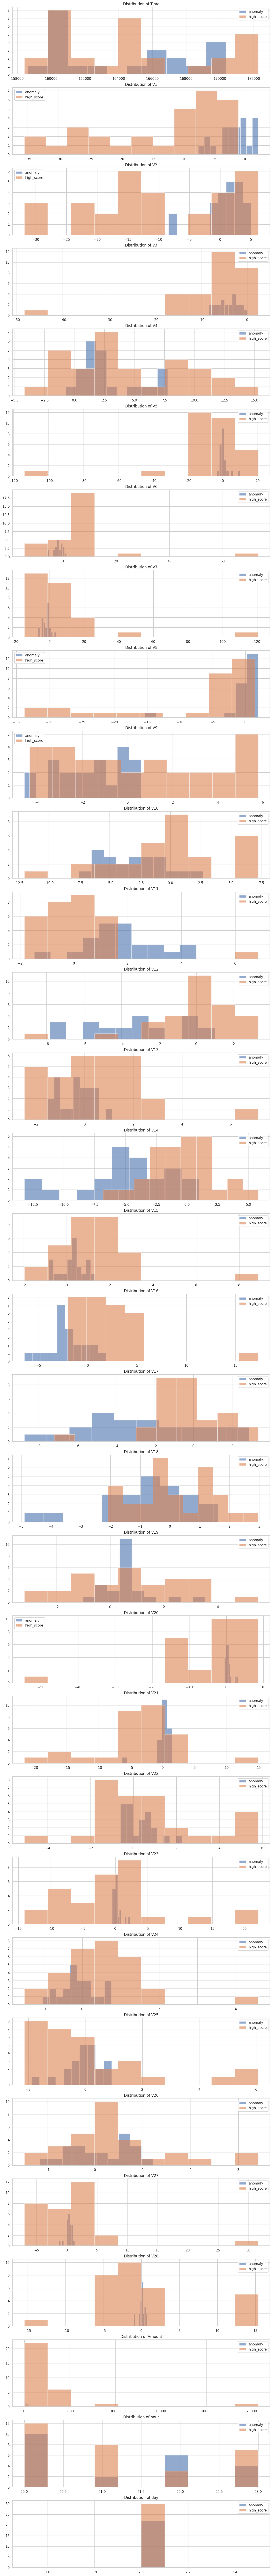

In [ ]:
high_score = X_test.iloc[np.argsort(scores)[-30:]]
anomaly = X_test.iloc[np.where(y_test == 1)]
datasets = [anomaly, high_score]
names = ['anomaly', 'high_score']
plt.figure(figsize= (15,150))
for i in range(0,32):
    plt.subplot(32,1,i + 1)
    feature = anomaly.columns[i]
    plt.hist(datasets[0][feature], label='anomaly', alpha=0.6)
    plt.hist(datasets[1][feature], label='high_score', alpha=0.6)
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.show()

Скорее всего идея вот в чем, объекты с высокой оценкой попали в одинаковое время транзакций, что и аномалии. Скорее всего гиперплоскость сначала отсекла именно по этим признакам. После отсечки у нас остались в вершине объекты с высокой оценкой и объекты аномалии. Вот здесь наступает важный момент - у объектов выше оценка - значит они отсекаются друг от друга гораздо быстрее, чем аномалии. А это означает, что эти объекты должны быть более равномерно распределены по области значений признаков. Вышеприведенный длинный график это и показывает - на многих признаках (Amount, V28, V23, V20, V9, V2) оранжевая шкала более равномерно распределена по горизонтали (а аномалии, наоборот, как будто в одной кучке)

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=150, contamination=0.001)
pred_lof = np.where(lof.fit_predict(X_test_normalized) == -1, 1, 0)
print(roc_auc_score(y_test, pred_lof))
print(Cohen_Kappa(y_test, pred_lof))
print(MCC(y_test, pred_lof))

0.7269389137163831
0.39162242335082087
0.39537092306631993


Блин, вот эти всратые индусовские методы просто пипец, непонятно какого хера они так долго обучаются, вот с LOF, в документации сказано, что если не указывать n_jobs, то он по дефолту будет 1, однако если я так сделаю обучаться будет около 500 секунд. Потом если я укажу n_jobs = 1, то будет обучаться около 219 секунд. Сплошной сюр!

OneClassSVM вообще пока обучение дождаться не могу...

In [ ]:
from sklearn.svm import OneClassSVM
ocs = OneClassSVM()
pred_ocs = np.where(ocs.fit_predict(X_test_normalized) == -1, 1, 0)
print(roc_auc_score(y_test, pred_ocs))
print(Cohen_Kappa(y_test, pred_ocs))
print(MCC(y_test, pred_ocs))

0.7274044957818105
0.0014039277679103073
0.02527114786592161


У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

Вот здесь у меня произошло недопонимание немного...

Задание заключается видимо в том, что мы должны train прогнать через unsupervised, затем добавить к train pred от unsupervised как новый признак...
Ну и в финале обучаем опять бустинг и погнали, с train все более менее понятно.

Но вот с test несовсем все очевидно, потому что если unsupervised обучить только на train, а предсказывать на test, то с метрикой будут огромные проблемы (половину дня перебирал гиперпараметры)



In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=150, contamination=0.001, novelty=True)
lof.fit(X_train_normalized)
pred = np.where(lof.predict(X_test_normalized) == -1, 1, 0)
print(roc_auc_score(y_test, pred))
print(Cohen_Kappa(y_test, pred))
print(MCC(y_test, pred))

0.5214271567709847
0.019447284276731924
0.023231648493478828


Ну и судя по такой метрике на тесте мы картину только испортим, поэтому уместнее на test также сделать fit_predict, тогда скорее всего метрики повысятся

В целом, это относительно логично, что unsupervised мы прогоняем только на одной выборке и сразу предсказываем (на это намекает как миниуму дефолтный параметр в localoutlierfactor "novelty"). А выбить норм метрику на незнакомых данных будет сложновато.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X_train['lof'] = LocalOutlierFactor(n_neighbors=150, contamination=0.001).fit_predict(X_train_normalized)
X_train['if'] = IsolationForest(n_estimators = 105, max_samples = int(X_train.shape[0] * 0.01), contamination = 0.0095).fit_predict(X_train_normalized)
eif1 = ExtendedIsolationForest(n_trees=105, subsample_rate=0.01, max_depth=5, contamination=0.0095)
eif1.fit(X_train_normalized)
X_train['eif'] = eif1.predict(X_train_normalized)[0]

X_test['lof'] = LocalOutlierFactor(n_neighbors=150, contamination=0.001).fit_predict(X_test_normalized)
X_test['if'] = IsolationForest(n_estimators = 105, max_samples = int(X_train.shape[0] * 0.01), contamination = 0.0095).fit_predict(X_test_normalized)
eif2 = ExtendedIsolationForest(n_trees=105, subsample_rate=0.01, max_depth=5, contamination=0.0095)
eif2.fit(X_test_normalized)
X_test['eif'] = eif2.predict(X_test_normalized)[0]


In [ ]:
sm = SVMSMOTE(sampling_strategy=0.05, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
cb = CatBoostClassifier(num_trees=150, learning_rate=1e-1, random_state=42)
cb.fit(X_res, y_res)
pred = cb.predict(X_test)

print(Cohen_Kappa(y_test, pred))
print(MCC(y_test, pred))
print(roc_auc_score(y_test, pred))

0:	learn: 0.4072272	total: 56ms	remaining: 8.34s
1:	learn: 0.2414174	total: 112ms	remaining: 8.29s
2:	learn: 0.1379836	total: 170ms	remaining: 8.35s
3:	learn: 0.0835942	total: 238ms	remaining: 8.67s
4:	learn: 0.0547549	total: 300ms	remaining: 8.69s
5:	learn: 0.0351110	total: 364ms	remaining: 8.74s
6:	learn: 0.0248494	total: 426ms	remaining: 8.71s
7:	learn: 0.0187684	total: 483ms	remaining: 8.57s
8:	learn: 0.0146620	total: 541ms	remaining: 8.48s
9:	learn: 0.0119688	total: 594ms	remaining: 8.32s
10:	learn: 0.0102144	total: 648ms	remaining: 8.18s
11:	learn: 0.0089129	total: 715ms	remaining: 8.22s
12:	learn: 0.0078873	total: 782ms	remaining: 8.24s
13:	learn: 0.0071317	total: 885ms	remaining: 8.6s
14:	learn: 0.0063613	total: 1s	remaining: 9.03s
15:	learn: 0.0058971	total: 1.13s	remaining: 9.42s
16:	learn: 0.0056471	total: 1.24s	remaining: 9.74s
17:	learn: 0.0052340	total: 1.37s	remaining: 10s
18:	learn: 0.0048824	total: 1.5s	remaining: 10.4s
19:	learn: 0.0045655	total: 1.64s	remaining: 10.6

Похуже получилось, скорее всего потому что unsupervised показывает все равно относительно плохие результаты, и из-за этого возникает ложные сэмплы, которые путают бустинг

Я не стал вставлять OneClassSVM, он итак показывает достаточно низкий результат, плюс еще и учится бесконечность по времени на train (я так и не дождался конца обучения)

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла.

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

-0.30165536962552353